# Factor 模块功能演示

本notebook演示betalens因子分析模块的全部功能，包括：
- 单因子分组与回测
- 双因子分组（独立排序 & 条件排序）
- 多因子递归分组
- 权重生成（经典多空 & 自定义模式）
- 绩效分析

In [7]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path

sys.path.insert(0, str(Path('.').resolve()))

from datafeed import Datafeed, get_absolute_trade_days
from backtest import BacktestBase
from analyst import PortfolioAnalyzer, ReportExporter
from factor.factor import (
    get_tradable_pool,
    pre_query_factor_data,
    single_factor,
    double_factor,
    multi_factor,
    get_single_factor_weight,
    get_double_factor_weight,
    get_multi_factor_weight,
    describe_labeled_pool,
    describe_double_labeled_pool,
    describe_multi_labeled_pool
)

## 1. 生成调仓日序列

In [8]:
date_list = get_absolute_trade_days("2015-04-30", "2024-04-30", "Y")
print(f"调仓日数量: {len(date_list)}")
print(f"调仓日: {date_list}")

调仓日数量: 10
调仓日: [datetime.datetime(2015, 12, 31, 0, 0), datetime.datetime(2016, 12, 30, 0, 0), datetime.datetime(2017, 12, 29, 0, 0), datetime.datetime(2018, 12, 28, 0, 0), datetime.datetime(2019, 12, 31, 0, 0), datetime.datetime(2020, 12, 31, 0, 0), datetime.datetime(2021, 12, 31, 0, 0), datetime.datetime(2022, 12, 30, 0, 0), datetime.datetime(2023, 12, 29, 0, 0), datetime.datetime(2024, 4, 30, 0, 0)]


## 2. 获取可交易股票池

In [9]:
date_ranges, code_ranges = get_tradable_pool(date_list)
print(f"可交易池日期数: {len(date_ranges)}")
print(f"第一个调仓日可交易股票数: {len(code_ranges[0])}")

[Function: query_time_range start...]
[Function: query_time_range finished, spent time: 1.43s]
[Function: query_time_range start...]
[Function: query_time_range finished, spent time: 1.37s]
[Function: query_time_range start...]
[Function: query_time_range finished, spent time: 1.28s]
[Function: query_time_range start...]
[Function: query_time_range finished, spent time: 1.21s]
[Function: query_time_range start...]
[Function: query_time_range finished, spent time: 1.24s]
[Function: query_time_range start...]
[Function: query_time_range finished, spent time: 1.15s]
[Function: query_time_range start...]
[Function: query_time_range finished, spent time: 1.11s]
[Function: query_time_range start...]
[Function: query_time_range finished, spent time: 1.01s]
[Function: query_time_range start...]
[Function: query_time_range finished, spent time: 0.94s]
[Function: query_time_range start...]
[Function: query_time_range finished, spent time: 0.92s]
可交易池日期数: 10
第一个调仓日可交易股票数: 2372


---
# Part A: 单因子分组回测

## 3. 预查询因子数据

In [10]:
metric = "股息率(报告期)"
pre_queried_data = pre_query_factor_data(
    date_list, 
    metric, 
    time_tolerance=24*2*365,
    table_name="fundamental_data",
    date_ranges=date_ranges,
    code_ranges=code_ranges
)
print(f"预查询数据形状: {pre_queried_data.shape}")
pre_queried_data.head()

[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.40s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.34s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.28s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.17s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.13s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.15s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.09s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.12s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.07s]
[Function: query_nearest_before start...]
[Function: query_nearest_before

,code,input_ts,datetime,diff_hours,股息率(报告期),name
0,000001.SZ,2015-12-31 10:00:00,2015-03-13 15:00:00,7027.0000000000000000,1.5144,平安银行
1,000004.SZ,2015-12-31 10:00:00,NaT,None,NaN,None
2,000006.SZ,2015-12-31 10:00:00,2015-04-01 15:00:00,6571.0000000000000000,1.6298,深振业A
3,000008.SZ,2015-12-31 10:00:00,NaT,None,NaN,None
4,000009.SZ,2015-12-31 10:00:00,2015-04-29 15:00:00,5899.0000000000000000,0.2500,中国宝安


## 4. 单因子分组

In [11]:
quantiles = {metric: 10}
labeled_pool = single_factor(pre_queried_data, metric, quantiles)
print(f"标签池形状: {labeled_pool.shape}")
labeled_pool.head(10)

标签池形状: (39029, 2)


股息率(报告期)  股息率(报告期)_label
input_ts            code                               
2015-12-31 10:00:00 000001.SZ    1.5144             6.0
                    000004.SZ       NaN             NaN
                    000006.SZ    1.6298             6.0
                    000008.SZ       NaN             NaN
                    000009.SZ    0.2500             1.0
                    000010.SZ       NaN             NaN
                    000011.SZ    2.5671             7.0
                    000012.SZ   10.7527             9.0
                    000014.SZ    0.1625             0.0
                    000016.SZ    0.2016             0.0

## 5. 查看因子分组统计

In [12]:
pivot_stats = describe_labeled_pool(labeled_pool)
pivot_stats

count                                                  \
股息率(报告期)_label        0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   
input_ts                                                                    
2015-12-31 10:00:00   189   186   187   189   186   187   188   187   187   
2016-12-30 10:00:00   203   202   202   204   202   201   203   202   202   
2017-12-29 10:00:00   236   235   236   235   236   235   235   236   235   
2018-12-28 10:00:00   288   288   287   288   287   288   288   287   287   
2019-12-31 10:00:00   292   292   291   293   290   292   291   292   291   
2020-12-31 10:00:00   299   299   299   299   299   298   299   302   296   
2021-12-31 10:00:00   338   337   337   339   336   337   338   337   337   
2022-12-30 10:00:00   376   375   375   375   375   375   375   375   375   
2023-12-29 10:00:00   396   395   396   395   396   395   395   396   395   
2024-04-30 10:00:00   412   412   411   412   412   411   412   411   412   
Total                3029  3021  3021  3029  3019  3019  3024  3025  3017   

                           ...      mean                                \
股息率(报告期)_label        9.0  ...       1.0       2.0       3.0       4.0   
input_ts                   ...                                           
2015-12-31 10:00:00   188  ...  0.312258  0.488764  0.697098  0.939013   
2016-12-30 10:00:00   203  ...  0.292104  0.447350  0.640298  0.856389   
2017-12-29 10:00:00   236  ...  0.303400  0.454463  0.638183  0.857683   
2018-12-28 10:00:00   288  ...  0.303284  0.465974  0.661040  0.897338   
2019-12-31 10:00:00   292  ...  0.283381  0.443766  0.629606  0.863453   
2020-12-31 10:00:00   299  ...  0.285361  0.449759  0.642314  0.869786   
2021-12-31 10:00:00   338  ...  0.327163  0.511935  0.726191  0.970632   
2022-12-30 10:00:00   375  ...  0.363075  0.551857  0.783798  1.022950   
2023-12-29 10:00:00   396  ...  0.358245  0.535858  0.730547  0.966165   
2024-04-30 10:00:00   412  ...  0.352667  0.534536  0.743092  0.984041   
Total                3027  ...  0.323407  0.495772  0.697945  0.932702   

                                                                       \
股息率(报告期)_label            5.0       6.0       7.0       8.0       9.0   
input_ts                                                                
2015-12-31 10:00:00  1.264261  1.659906  2.231324  3.219867  7.549093   
2016-12-30 10:00:00  1.155285  1.530552  2.053004  3.054273  6.987587   
2017-12-29 10:00:00  1.142440  1.483798  1.918550  2.735651  6.624042   
2018-12-28 10:00:00  1.195278  1.539858  2.039294  2.936145  7.320367   
2019-12-31 10:00:00  1.162285  1.526448  2.070855  3.047438  7.653370   
2020-12-31 10:00:00  1.152181  1.539831  2.101040  3.016655  6.917053   
2021-12-31 10:00:00  1.258835  1.649951  2.246447  3.274076  7.111627   
2022-12-30 10:00:00  1.313004  1.738283  2.367757  3.405576  7.752754   
2023-12-29 10:00:00  1.265519  1.647644  2.237317  3.185322  6.956154   
2024-04-30 10:00:00  1.285555  1.686085  2.206680  3.106268  5.679553   
Total                1.228528  1.611960  2.164333  3.116607  7.009533   

                               
股息率(报告期)_label          Total  
input_ts                       
2015-12-31 10:00:00  1.850542  
2016-12-30 10:00:00  1.715272  
2017-12-29 10:00:00  1.630053  
2018-12-28 10:00:00  1.749648  
2019-12-31 10:00:00  1.781547  
2020-12-31 10:00:00  1.709513  
2021-12-31 10:00:00  1.822768  
2022-12-30 10:00:00  1.946080  
2023-12-29 10:00:00  1.805546  
2024-04-30 10:00:00  1.674528  
Total                1.773009  

[11 rows x 22 columns]

## 6. 生成单因子权重 - 经典多空模式

In [13]:
params_classic = {
    'factor_key': metric,
    'mode': 'classic-long-short'
}
weights_classic = get_single_factor_weight(labeled_pool, params_classic)
print(f"权重形状: {weights_classic.shape}")
print(f"非零权重数量: {(weights_classic != 0).sum().sum()}")
weights_classic.head()

权重形状: (10, 2204)
非零权重数量: 6056


code,000001.SZ,000002.SZ,000011.SZ,000012.SZ,000014.SZ,000016.SZ,000025.SZ,000030.SZ,000031.SZ,000032.SZ,...,872953.BJ,873339.BJ,873593.BJ,873679.BJ,873693.BJ,873703.BJ,920167.BJ,920445.BJ,920682.BJ,920819.BJ
input_ts,,,,,,,,,,,,,,,,,,,,,
2015-12-31 10:00:00,0.0,0.000000,0.0,0.005319,-0.005291,-0.005291,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-30 10:00:00,0.0,0.004926,0.0,0.004926,0.000000,-0.004926,0.0,0.0,0.000000,-0.004926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-29 10:00:00,0.0,0.004237,0.0,0.000000,-0.004237,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-28 10:00:00,0.0,0.003472,0.0,0.000000,-0.003472,0.000000,0.0,0.0,0.000000,-0.003472,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-31 10:00:00,0.0,0.003425,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.003425,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 7. 生成单因子权重 - 自定义模式 (freeplay)

In [14]:
params_freeplay = {
    'factor_key': metric,
    'mode': 'freeplay',
    'long': [9],
    'short': [0]
}
weights_freeplay = get_single_factor_weight(labeled_pool, params_freeplay)
print(f"权重形状: {weights_freeplay.shape}")
print(f"每行权重和: [{weights_freeplay.sum(axis=1).min():.4f}, {weights_freeplay.sum(axis=1).max():.4f}]")
weights_freeplay.head()

权重形状: (10, 2204)
每行权重和: [-0.0000, 0.0000]


C:\Users\Janis\OneDrive\factor-frame\betalens\factor\factor.py:651: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.005319148936170213' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group.loc[mask, weight_col] = group_weight / len(group_stocks)
C:\Users\Janis\OneDrive\factor-frame\betalens\factor\factor.py:651: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0049261083743842365' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group.loc[mask, weight_col] = group_weight / len(group_stocks)
C:\Users\Janis\OneDrive\factor-frame\betalens\factor\factor.py:651: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00423728813559322' has dtype incompatible with int64, plea

code,000001.SZ,000002.SZ,000011.SZ,000012.SZ,000014.SZ,000016.SZ,000025.SZ,000030.SZ,000031.SZ,000032.SZ,...,872953.BJ,873339.BJ,873593.BJ,873679.BJ,873693.BJ,873703.BJ,920167.BJ,920445.BJ,920682.BJ,920819.BJ
input_ts,,,,,,,,,,,,,,,,,,,,,
2015-12-31 10:00:00,0.0,0.000000,0.0,0.005319,-0.005291,-0.005291,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-30 10:00:00,0.0,0.004926,0.0,0.004926,0.000000,-0.004926,0.0,0.0,0.000000,-0.004926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-29 10:00:00,0.0,0.004237,0.0,0.000000,-0.004237,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-28 10:00:00,0.0,0.003472,0.0,0.000000,-0.003472,0.000000,0.0,0.0,0.000000,-0.003472,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-31 10:00:00,0.0,0.003425,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.003425,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 8. 高级权重配置：组间权重 + 组内因子值分配

In [15]:
params_advanced = {
    'factor_key': metric,
    'mode': 'freeplay',
    'long': [8, 9],
    'short': [0, 1],
    'group_weights': {
        'long': {8: 1, 9: 2},
        'short': {0: 2, 1: 1}
    },
    'intra_group_allocation': {
        'long': {
            9: {'method': 'factor_value', 'metric': metric, 'order': 'desc'}
        },
        'short': {
            0: {'method': 'factor_value', 'metric': metric, 'order': 'asc'}
        }
    }
}
weights_advanced = get_single_factor_weight(labeled_pool, params_advanced)
print(f"高级权重形状: {weights_advanced.shape}")
weights_advanced.head()

高级权重形状: (10, 3526)


C:\Users\Janis\OneDrive\factor-frame\betalens\factor\factor.py:651: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0017825311942959' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group.loc[mask, weight_col] = group_weight / len(group_stocks)
C:\Users\Janis\OneDrive\factor-frame\betalens\factor\factor.py:651: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00165016501650165' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group.loc[mask, weight_col] = group_weight / len(group_stocks)
C:\Users\Janis\OneDrive\factor-frame\betalens\factor\factor.py:651: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0014184397163120566' has dtype incompatible with int64, please

code,000001.SZ,000002.SZ,000006.SZ,000008.SZ,000009.SZ,000011.SZ,000012.SZ,000014.SZ,000016.SZ,000019.SZ,...,873593.BJ,873679.BJ,873693.BJ,873703.BJ,873833.BJ,920167.BJ,920445.BJ,920682.BJ,920799.BJ,920819.BJ
input_ts,,,,,,,,,,,,,,,,,,,,,
2015-12-31 10:00:00,0.0,0.000000,0.000000,0.000000,-0.001792,0.000000,0.006740,-0.002348,-0.000835,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-30 10:00:00,0.0,0.007315,0.000000,0.000000,0.000000,0.000000,0.002717,-0.001650,-0.000594,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-29 10:00:00,0.0,0.007503,0.000000,-0.001418,-0.001418,0.000000,0.000000,-0.003014,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-28 10:00:00,0.0,0.006272,0.001161,0.000000,-0.001157,0.001161,0.000000,-0.003645,0.001161,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-31 10:00:00,0.0,0.007207,0.001145,0.000000,-0.001142,0.001145,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 9. 单因子回测

[Function: query_nearest_after start...]
[Function: query_nearest_after finished, spent time: 8.27s]


C:\Users\Janis\OneDrive\factor-frame\betalens\backtest\backtest.py:233: UserWarning: pivot_table 结果缺少部分标的: 7/2204
缺失示例: ['002752.SZ', '688279.SH', '920819.BJ', '920167.BJ', '920682.BJ']
修复建议: 检查数据库查询结果是否包含这些标的
  warnings.warn(
C:\Users\Janis\OneDrive\factor-frame\betalens\backtest\backtest.py:545: UserWarning: 部分标的在数据库中无数据 (7/2204):
  缺失: ['002752.SZ', '688279.SH', '832566.BJ', '920167.BJ', '920445.BJ', '920682.BJ', '920819.BJ']
  数据样本:
  形状: (10, 2198)
  索引类型: MultiIndex
  索引层级: ['input_ts', 'datetime']
  索引样本: [(Timestamp('2015-12-31 10:00:00'), Timestamp('2015-12-31 15:00:01')), (Timestamp('2016-12-30 10:00:00'), Timestamp('2016-12-30 15:00:01')), (Timestamp('2017-12-29 10:00:00'), Timestamp('2017-12-29 15:00:01'))]
  列名: ['000001.SZ', '000002.SZ', '000011.SZ', '000012.SZ', '000014.SZ']...
  数据样本:
                                         000001.SZ  000002.SZ 000011.SZ 000012.SZ 000014.SZ
input_ts            datetime                                                               
2015

  [警告] 标的 002752.SZ 权重已置零
  [警告] 标的 688279.SH 权重已置零
  [警告] 标的 920819.BJ 权重已置零
  [警告] 标的 920167.BJ 权重已置零
  [警告] 标的 920682.BJ 权重已置零
  [警告] 标的 920445.BJ 权重已置零
  [警告] 标的 832566.BJ 权重已置零


C:\Users\Janis\OneDrive\factor-frame\betalens\backtest\backtest.py:645: UserWarning: amount 计算后包含 2268 个 NaN 值
修复建议: 检查 cost_ret 和 weight 的数据完整性
  warnings.warn(
C:\Users\Janis\OneDrive\factor-frame\betalens\backtest\backtest.py:663: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.amount['amount'] = sum_series.cumprod() * self.initial_amount


[Function: query_time_range start...]
[Function: query_time_range finished, spent time: 35.76s]


C:\Users\Janis\OneDrive\factor-frame\betalens\backtest\backtest.py:233: UserWarning: pivot_table 结果缺少部分标的: 7/2204
缺失示例: ['002752.SZ', '688279.SH', '920819.BJ', '920167.BJ', '920682.BJ']
修复建议: 检查数据库查询结果是否包含这些标的
  warnings.warn(
C:\Users\Janis\OneDrive\factor-frame\betalens\backtest\backtest.py:333: UserWarning: 计算输入参数 'cost_price' 包含 NaN 值
数据样本:
形状: (10, 2198)
  索引类型: MultiIndex
  索引层级: ['input_ts', 'datetime']
  索引样本: [(Timestamp('2015-12-31 10:00:00'), Timestamp('2015-12-31 15:00:01')), (Timestamp('2016-12-30 10:00:00'), Timestamp('2016-12-30 15:00:01')), (Timestamp('2017-12-29 10:00:00'), Timestamp('2017-12-29 15:00:01'))]
  列名: ['000001.SZ', '000002.SZ', '000011.SZ', '000012.SZ', '000014.SZ']...
  数据样本:
                                         000001.SZ  000002.SZ 000011.SZ 000012.SZ 000014.SZ
input_ts            datetime                                                               
2015-12-31 10:00:00 2015-12-31 15:00:01  1031.0691  3113.5416   48.5744  228.5973  122.3128
2016-12-

<Axes: title={'center': '单因子策略净值曲线'}, xlabel='datetime'>

C:\Users\Janis\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 21333 (\N{CJK UNIFIED IDEOGRAPH-5355}) missing from font(s) DejaVu Serif.
  func(*args, **kwargs)
C:\Users\Janis\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 22240 (\N{CJK UNIFIED IDEOGRAPH-56E0}) missing from font(s) DejaVu Serif.
  func(*args, **kwargs)
C:\Users\Janis\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from font(s) DejaVu Serif.
  func(*args, **kwargs)
C:\Users\Janis\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from font(s) DejaVu Serif.
  func(*args, **kwargs)
C:\Users\Janis\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 30053 (\N{CJK

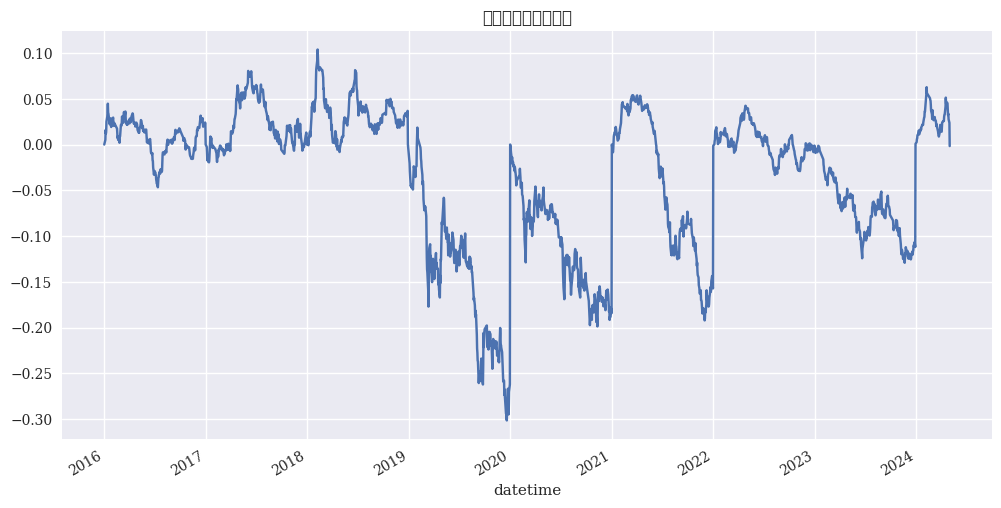

In [16]:
weights_bt = weights_freeplay.copy()
weights_bt['cash'] = 0

bb = BacktestBase(weight=weights_bt, symbol="", amount=1000000)
bb.nav.plot(title="单因子策略净值曲线", figsize=(12, 6))

## 10. 单因子绩效分析

In [17]:
analyzer = PortfolioAnalyzer(bb.nav)
exporter = ReportExporter(analyzer)
exporter.generate_annual_report()

+----------------------------------------------------+
|                   分年度绩效报告                   |
+------+----------+------------+----------+----------+
| 指标 |  Return  | Volatility |  MaxDD   |  Sharpe  |
+------+----------+------------+----------+----------+
| 2016 | -100.00% | 89565.78%  | 204.59%  | -110.72% |
| 2017 | -100.00% | 13915.82%  | 317.56%  | -96.83%  |
| 2018 | -100.00% |  1441.01%  | 118.07%  |  -4.46%  |
| 2019 | -100.00% |  757.52%   | 1728.98% | -31.62%  |
| 2020 | -100.00% |  219.30%   |  -0.00%  | 197.03%  |
| 2021 | -84.39%  |  1157.98%  | 456.27%  |  9.34%   |
| 2022 | -426.72% |  4032.27%  | 178.40%  | -151.30% |
| 2023 | -108.86% |  246.91%   |  0.00%   | 165.40%  |
| 2024 | -162.85% |  402.12%   | 102.68%  | 210.81%  |
+------+----------+------------+----------+----------+


---
# Part B: 双因子分组回测

## 11. 预查询双因子数据

In [18]:
metric1 = "市净率"
metric2 = "股息率(报告期)"

pre_queried_data1 = pre_query_factor_data(
    date_list, metric1, time_tolerance=24*2*365,
    table_name="fundamental_data",
    date_ranges=date_ranges, code_ranges=code_ranges
)

pre_queried_data2 = pre_query_factor_data(
    date_list, metric2, time_tolerance=24*2*365,
    table_name="fundamental_data",
    date_ranges=date_ranges, code_ranges=code_ranges
)

print(f"主因子({metric1})数据量: {len(pre_queried_data1)}")
print(f"次因子({metric2})数据量: {len(pre_queried_data2)}")

[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.46s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.36s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.36s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.36s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.54s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.26s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.25s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.25s]
[Function: query_nearest_before start...]
[Function: query_nearest_before finished, spent time: 1.29s]
[Function: query_nearest_before start...]
[Function: query_nearest_before

## 12. 双因子分组 - 条件排序 (Dependent Sort)

In [19]:
quantiles1 = {metric1: 5}
quantiles2 = {metric2: 5}

labeled_pool_dependent = double_factor(
    pre_queried_data1, pre_queried_data2,
    metric1, metric2,
    quantiles1, quantiles2,
    sort_method='dependent'
)

print(f"条件排序标签池形状: {labeled_pool_dependent.shape}")
labeled_pool_dependent.head()

条件排序标签池形状: (39029, 4)


市净率  股息率(报告期)  市净率_label  股息率(报告期)_label
input_ts            code                                               
2015-12-31 10:00:00 000001.SZ  NaN    1.5144        NaN               0
                    000004.SZ  NaN       NaN        NaN               0
                    000006.SZ  NaN    1.6298        NaN               0
                    000008.SZ  NaN       NaN        NaN               0
                    000009.SZ  NaN    0.2500        NaN               0

## 13. 双因子分组 - 独立排序 (Independent Sort)

In [20]:
labeled_pool_independent = double_factor(
    pre_queried_data1, pre_queried_data2,
    metric1, metric2,
    quantiles1, quantiles2,
    sort_method='independent'
)

print(f"独立排序标签池形状: {labeled_pool_independent.shape}")
labeled_pool_independent.head()

独立排序标签池形状: (39029, 4)


市净率  股息率(报告期)  市净率_label  股息率(报告期)_label
input_ts            code                                               
2015-12-31 10:00:00 000001.SZ  NaN    1.5144        NaN             3.0
                    000004.SZ  NaN       NaN        NaN             NaN
                    000006.SZ  NaN    1.6298        NaN             3.0
                    000008.SZ  NaN       NaN        NaN             NaN
                    000009.SZ  NaN    0.2500        NaN             0.0

## 14. 双因子分组统计对比

In [21]:
print("=== 条件排序统计 ===")
count_dep, mean1_dep, mean2_dep = describe_double_labeled_pool(labeled_pool_dependent)
print("各组合样本数:")
display(count_dep)

print("\n=== 独立排序统计 ===")
count_indep, mean1_indep, mean2_indep = describe_double_labeled_pool(labeled_pool_independent)
print("各组合样本数:")
display(count_indep)

=== 条件排序统计 ===

排序方法: DEPENDENT
  - Independent Sort: 独立排序，两因子分别独立分组后取交集
  - Dependent Sort: 条件排序，先按主因子分组，再在每组内按次因子分组

各组合样本数:


股息率(报告期)_label,0,Total
市净率_label,,
0,39029,39029
Total,39029,39029



=== 独立排序统计 ===

排序方法: INDEPENDENT
  - Independent Sort: 独立排序，两因子分别独立分组后取交集
  - Dependent Sort: 条件排序，先按主因子分组，再在每组内按次因子分组

各组合样本数:


股息率(报告期)_label,0,1,2,3,4,Total
市净率_label,,,,,,
0,14848,6050,6038,6049,6044,39029
Total,14848,6050,6038,6049,6044,39029


## 15. 双因子权重 - 经典多空

In [22]:
double_params_classic = {
    'factor_key1': metric1,
    'factor_key2': metric2,
    'mode': 'classic-long-short'
}
weights_double_classic = get_double_factor_weight(labeled_pool_dependent, double_params_classic)
print(f"双因子经典权重形状: {weights_double_classic.shape}")
weights_double_classic.head()

双因子经典权重形状: (0, 0)


code
input_ts


## 16. 双因子权重 - 自定义组合

In [23]:
double_params_freeplay = {
    'factor_key1': metric1,
    'factor_key2': metric2,
    'mode': 'freeplay',
    'long_combinations': [(0, 4), (1, 4)],
    'short_combinations': [(4, 0), (3, 0)]
}
weights_double_freeplay = get_double_factor_weight(labeled_pool_dependent, double_params_freeplay)
print(f"双因子自定义权重形状: {weights_double_freeplay.shape}")
weights_double_freeplay.head()

双因子自定义权重形状: (0, 0)


code
input_ts


## 17. 双因子回测

In [24]:
weights_double_bt = weights_double_freeplay.copy()
weights_double_bt['cash'] = 0

bb_double = BacktestBase(weight=weights_double_bt, symbol="", amount=1000000)
bb_double.nav.plot(title="双因子策略净值曲线", figsize=(12, 6))

BacktestDataError: weight 输入验证失败:
  weight 不能为空
修复建议: 检查输入数据源
  数据样本:
  空DataFrame

## 18. 双因子绩效分析

In [ ]:
analyzer_double = PortfolioAnalyzer(bb_double.nav)
exporter_double = ReportExporter(analyzer_double)
exporter_double.generate_annual_report()

---
# Part C: 多因子递归分组回测

## 19. 定义多因子配置

In [ ]:
factors_config = [
    {'name': '市值', 'quantiles': 3, 'method': 'dependent'},
    {'name': '账面市值比', 'quantiles': 3, 'method': 'dependent'},
    {'name': '股息率(报告期)', 'quantiles': 2, 'method': 'independent'}
]

total_combos = 1
for f in factors_config:
    total_combos *= f['quantiles']
print(f"预期形成 {total_combos} 个组合")

## 20. 预查询多因子数据

In [ ]:
pre_queried_data_list = []
for factor_config in factors_config:
    metric_name = factor_config['name']
    data = pre_query_factor_data(
        date_list, metric_name,
        time_tolerance=24*2*365,
        table_name="fundamental_data",
        date_ranges=date_ranges,
        code_ranges=code_ranges
    )
    pre_queried_data_list.append(data)
    print(f"{metric_name}: {len(data)} 条记录")

## 21. 多因子分组

In [ ]:
labeled_pool_multi = multi_factor(pre_queried_data_list, factors_config)
print(f"多因子标签池形状: {labeled_pool_multi.shape}")
labeled_pool_multi.head(10)

## 22. 多因子分组统计

In [ ]:
stats = describe_multi_labeled_pool(labeled_pool_multi, max_display_dims=2)
print("各组合样本数（前2个因子交叉）:")
display(stats['count_pivot'])

print("\n各因子在各组合中的均值:")
for factor_name, mean_pivot in stats['mean_pivots'].items():
    print(f"\n{factor_name}:")
    display(mean_pivot)

## 23. 多因子权重 - 经典多空

In [ ]:
multi_params_classic = {
    'mode': 'classic-long-short'
}
weights_multi_classic = get_multi_factor_weight(labeled_pool_multi, multi_params_classic)
print(f"多因子经典权重形状: {weights_multi_classic.shape}")
weights_multi_classic.head()

## 24. 多因子权重 - 自定义组合

In [ ]:
multi_params_freeplay = {
    'mode': 'freeplay',
    'long_combinations': [
        (0, 2, 1),
        (1, 2, 1)
    ],
    'short_combinations': [
        (2, 0, 0),
        (2, 1, 0)
    ]
}
weights_multi_freeplay = get_multi_factor_weight(labeled_pool_multi, multi_params_freeplay)
print(f"多因子自定义权重形状: {weights_multi_freeplay.shape}")
weights_multi_freeplay.head()

## 25. 多因子回测

In [ ]:
weights_multi_bt = weights_multi_freeplay.copy()
weights_multi_bt['cash'] = 0

bb_multi = BacktestBase(weight=weights_multi_bt, symbol="", amount=1000000)
bb_multi.nav.plot(title="多因子策略净值曲线", figsize=(12, 6))

## 26. 多因子绩效分析

In [ ]:
analyzer_multi = PortfolioAnalyzer(bb_multi.nav)
exporter_multi = ReportExporter(analyzer_multi)
exporter_multi.generate_annual_report()

---
# Part D: 策略对比

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 7))

bb.nav.plot(ax=ax, label='单因子')
bb_double.nav.plot(ax=ax, label='双因子')
bb_multi.nav.plot(ax=ax, label='多因子')

ax.set_title('因子策略净值对比')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
# Part E: 自定义时段绩效报告

In [ ]:
print("=== 单因子 2020-2024 绩效 ===")
exporter.generate_custom_report('2020-01-01', '2024-04-30')

print("\n=== 双因子 2020-2024 绩效 ===")
exporter_double.generate_custom_report('2020-01-01', '2024-04-30')

print("\n=== 多因子 2020-2024 绩效 ===")
exporter_multi.generate_custom_report('2020-01-01', '2024-04-30')